## Visualizing the distribution of the observations

## Load the required libraries

In [91]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import matplotlib.pyplot as plt

import sys
sys.path.append('./lib')

import findspark

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions


from numpy_pack import packArray,unpackArray
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

    pandas as    pd 	version=0.19.1 	required version>=0.19.2 ******* Update Version ******
     numpy as    np 	version=1.11.2 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [2]:
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBBSS'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df=sqlContext.read.parquet(filename)

In [75]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation FROM weather"
df1 = sqlContext.sql(Query)
df2 = df1.toPandas()

In [173]:
def getSortedStationList(file_index,meas,sortParam = 'elevation'):
    
    filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
    df=sqlContext.read.parquet(filename)
    sqlContext.registerDataFrameAsTable(df,'weather')
    Query="SELECT station, latitude,longitude,elevation FROM weather"
    df1 = sqlContext.sql(Query)
    df2 = df1.toPandas()

    df_elevation = df2.sort_values(by=[sortParam], ascending=[True])
    df_elevation.drop_duplicates(subset=None, keep='first', inplace=True)

    station_list = df_elevation['station']
    return station_list

In [183]:
from scipy.special import gammaln,factorial

def G(n):
    return gammaln(n+1)

def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m

def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~np.isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    return logprob,m

def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(6,6))
    axes.imshow(mat, cmap=plt.cm.gray)
    
def computeProbMatrix(Stations,All):
    L=len(Stations)
    Pvals=np.zeros([L,L])
    Length=np.zeros([L,L])
    P_norm=np.zeros([L,L])
    for i in range(L):
        print i,
        for j in range(L):
            if i==j: 
                P_norm[i,j]=-0.4
                continue
            X=np.copy(All[Stations[i]])
            Y=np.copy(All[Stations[j]])
            P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
            if Length[i,j]<200:
                P_norm[i,j]=np.nan
    return P_norm

In [64]:
def getStationMeasValues(file_index,meas,station_list):
        #read data
    filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
    df_in=sqlContext.read.parquet(filename)
    df_in_2=df_in.filter(df_in.measurement==meas)
    rows=df_in_2.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
    ## combine the measurements for each station into a single long array with an entry for each day of each day
    days=set([r[1] for r in rows])
    miny=min(days)
    maxy=max(days)
    record_len=int((maxy-miny+1)*365)
    record_len
    All={}  # a dictionary with a numpy array for each day of each day
    i=0
    for station,day,vector in rows:
        i+=1; 
        # if i%1000==0: print i,len(All)
        if not station in All:
            a=np.zeros(record_len)
            a.fill(np.nan)
            All[station]=a
        loc = int((day-miny)*365)
        All[station][loc:loc+365]=vector
    
    Stations = []
    
    for station in station_list:
        Stations.append(station)

    return([Stations, All])

In [178]:
def createTiles(x=1,y=1,hwidth=8,vwidth=4): 
    fig,plots = plt.subplots(x,y,figsize=(hwidth,vwidth));
    plots = plots.flatten()
    return(fig, plots)

## Analysis on basis of elevation

0

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42

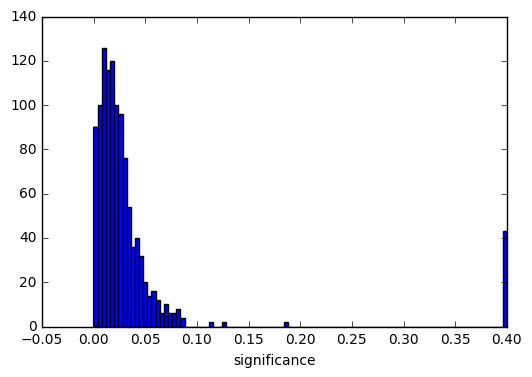

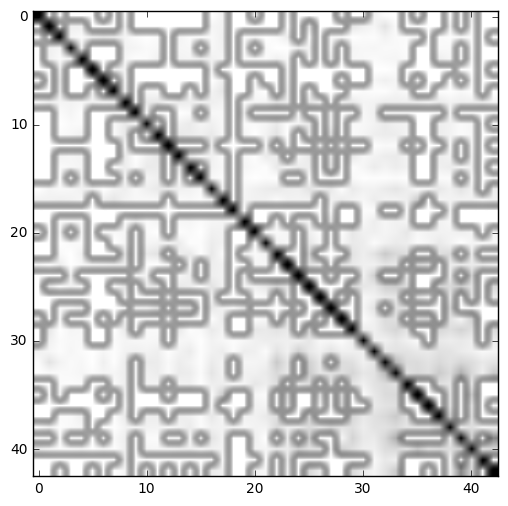

In [197]:
meas = 'SNOW'
station_list = getSortedStationList(file_index,meas,sortParam='elevation')
[Stations,All] = getStationMeasValues(file_index,meas,station_list)


P_norm = computeProbMatrix(Stations,All)
A=P_norm.flatten();
B=A[~np.isnan(A)]
plt.hist(-B,100)
plt.xlabel('significance')
plt.show()
showmat(P_norm)
plt.imshow(P_norm,cmap='gray')
plt.show()

0

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93

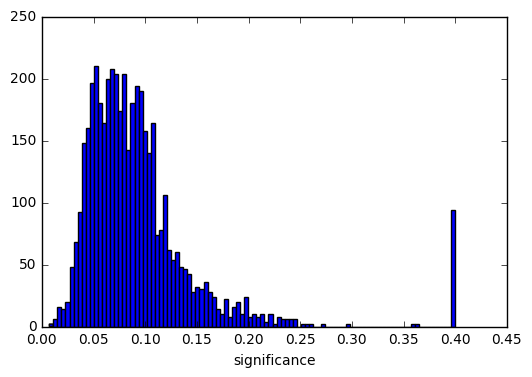

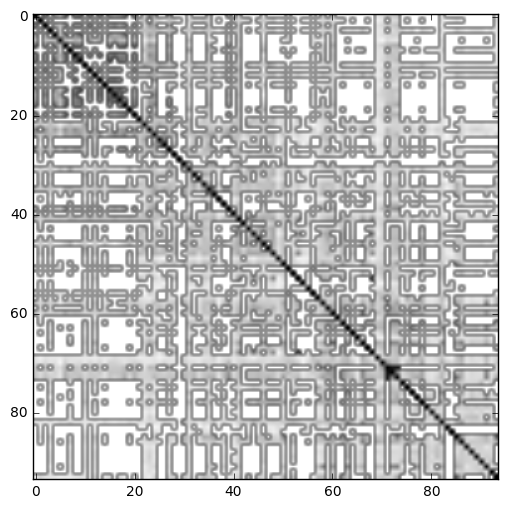

In [187]:
meas = 'PRCP'
station_list = getSortedStationList(file_index,meas,sortParam='elevation')
[Stations,All] = getStationMeasValues(file_index,meas,station_list)


P_norm = computeProbMatrix(Stations,All)
A=P_norm.flatten();
B=A[~np.isnan(A)]
plt.hist(-B,100)
plt.xlabel('significance')
plt.show()
showmat(P_norm)
plt.imshow(P_norm,cmap='gray')
plt.show()

## Trend of Precipitation/Rain vs Longitude 

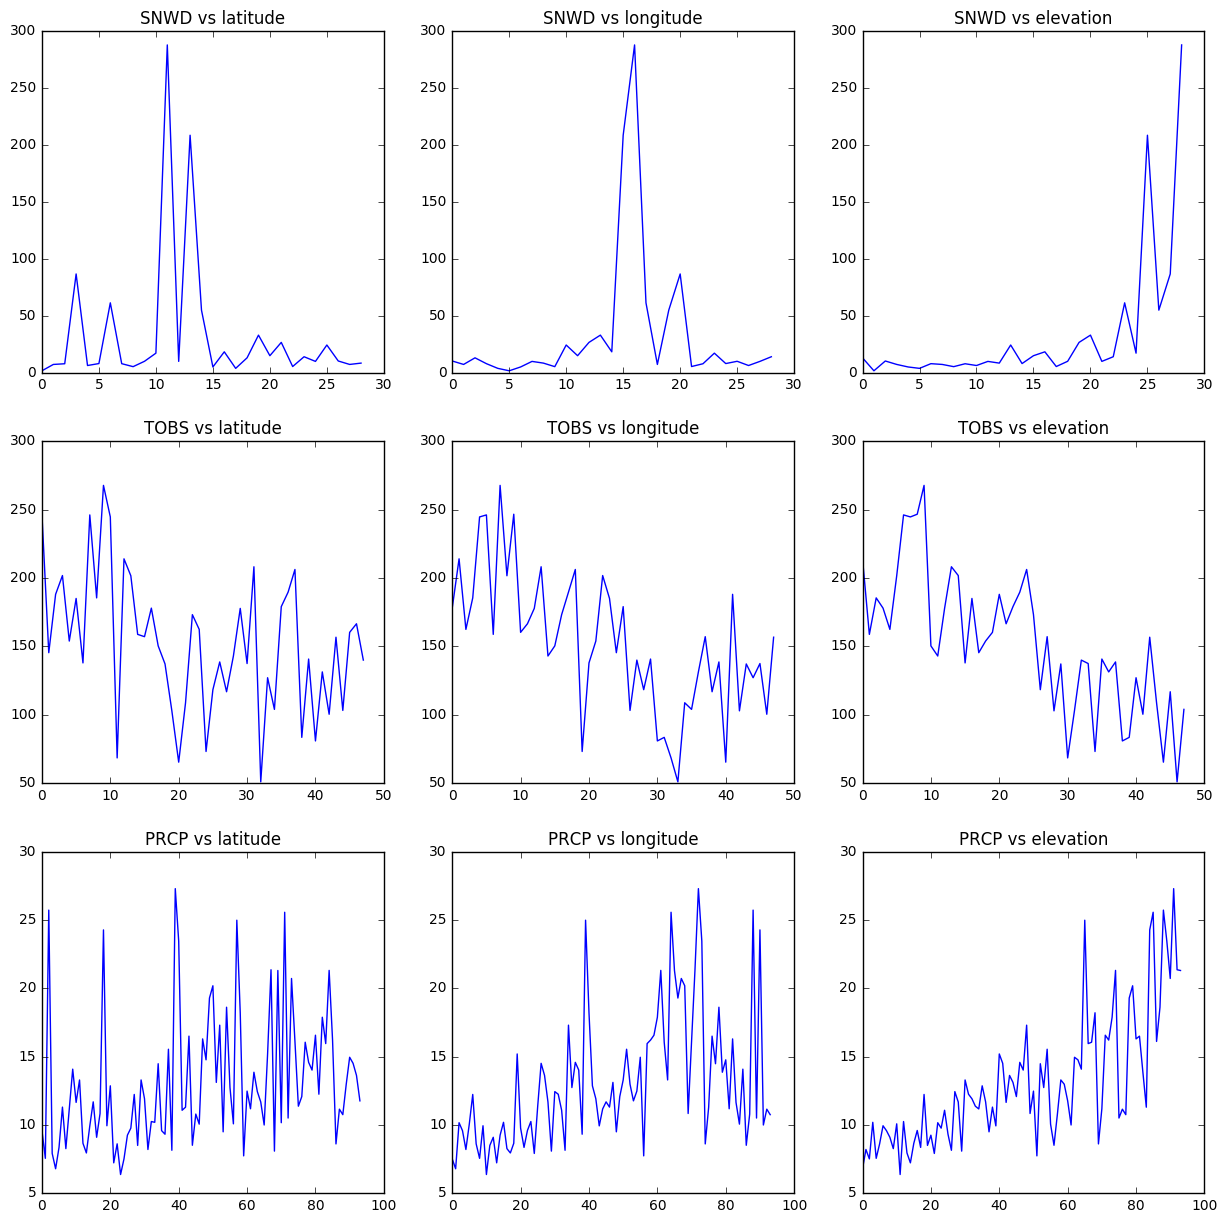

In [182]:
plotIndex = 0
measList = ['SNWD','TOBS','PRCP']
sortParamList = ['latitude','longitude','elevation']
fig, plots = createTiles(3,3,15,15)

for meas in measList:
    for sortParam in sortParamList:

        station_list = getSortedStationList(file_index,meas,sortParam=sortParam)
        [Stations,All] = getStationMeasValues(file_index,meas,station_list)

        dataList = []
        for station in Stations:
            dataList.append(np.nanmean(All[station]))

        plots[plotIndex].plot(dataList)
        plots[plotIndex].set_title(meas + ' vs '+sortParam)
        plotIndex = plotIndex + 1
fig

In [ ]:
df = df.sort_values(by=['c1','c2'], ascending=[False,True])